In [9]:
import glob, matplotlib, re, math, pandas, sys, argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from models import autoencoder
import torch
randomSeed = 5
import pytorch_lightning as pl
pl.seed_everything(randomSeed)
torch.manual_seed(randomSeed)
import random
random.seed(randomSeed)
np.random.seed(randomSeed)
from torch import nn, FloatTensor
from torch.autograd import Variable
from data_ttMET_delphes import get_DataLoaders
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

Global seed set to 5


In [33]:
args = argparse.Namespace()
args.data = '/users/whopkins/sigclustering/sigclustering/python/ttMET_delphes_sepSigs.h5'
args.time_throughput = False
args.batch_size = 512
loadBranches = ['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good', 'num_bjets', 'm_1jet']
signals = ['sig_1300_1', 'sig_700_400']#, 'sig_800_1' , 'sig_800_500']
trainDataLoader, testDataLoader, allData, scaledData, selectedSigs, reducedData = get_DataLoaders(args, loadBranches, signals=signals, minSize=1000, reduceData=True)#, scaler=quantScaler)
print(allData.keys())


No preselection specified
Number of signal samples: 2
Total number of events to be clustered: 51478
We will make all samples have the following raw event yield: 14484
using only samples:  ['sig_1300_1', 'sig_700_400']
aeData.shape: (28968, 9)
aeData.columns: Index(['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good',
       'num_bjets', 'm_1jet'],
      dtype='object')
tempWeights.shape: (28968, 91)
samples: ['sig_1300_1', 'sig_700_400']
tmp =      MET   HT  pT_1jet  pT_2jet  pT_3jet  pT_4jet  nj_good  num_bjets  m_1jet
min  0.0  0.0      0.0      0.0    -0.05    -0.05      0.0        0.0     0.0
max  1.0  1.0      1.0      1.0     1.00     1.00      1.0        1.0     1.0
Index(['nj_good', 'num_bjets', 'pT_1jet', 'eta_1jet', 'phi_1jet', 'm_1jet',
       'pT_2jet', 'eta_2jet', 'phi_2jet', 'm_2jet', 'pT_3jet', 'eta_3jet',
       'phi_3jet', 'm_3jet', 'pT_4jet', 'eta_4jet', 'phi_4jet', 'm_4jet',
       'pT_5jet', 'eta_5jet', 'phi_5jet', 'm_5jet', 'pT_6jet', 'eta_6jet',
   

(28968, 10)
_sig_1300_1__sig_700_400
MET 250.0 2077.0
HT 151.25 4741.0
pT_1jet 26.84018 2858.2334
pT_2jet 24.482592 1785.5057
pT_3jet -9999.0 1679.156
pT_4jet -9999.0 1757.535
nj_good 2 15


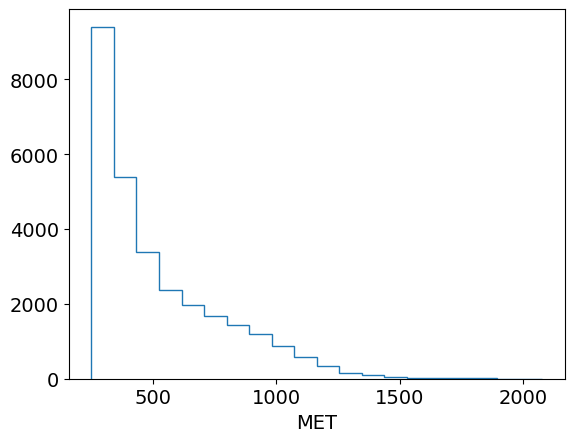

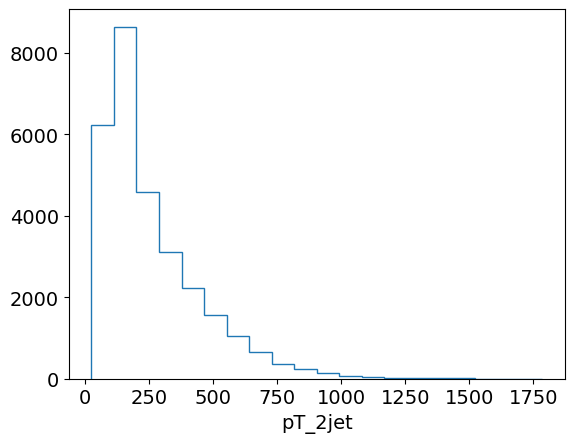

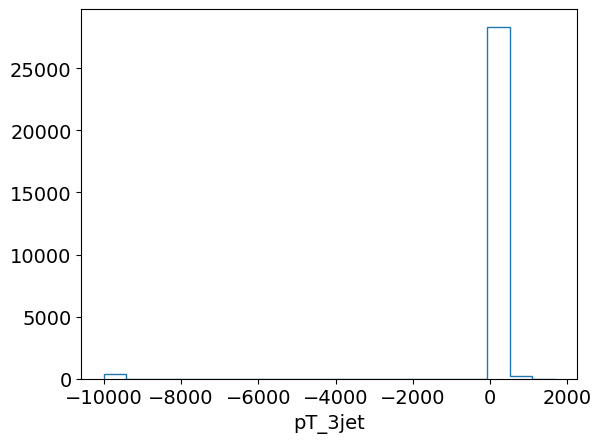

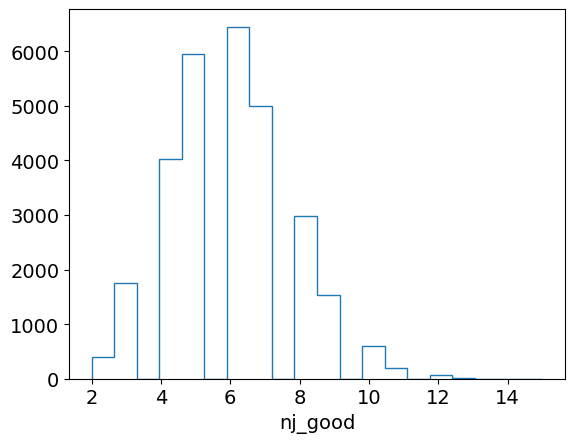

In [36]:
# Let's plot the input variables to make sure we don't have some ugly spikes
cDataWithName = scaledData
#print(scaledData)
doAvg = False
sumStr = ''
if doAvg:
    cDataWithName = reducedData
    sumStr = '_avg'
print(cDataWithName.shape)
trainBranches = ['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good']#, 'num_bjets']
varListStr = '_'.join(trainBranches)
data = cDataWithName[trainBranches].copy(deep=True)


# convert to tensors
data_t = FloatTensor(data.to_numpy())
dataset = TensorDataset(data_t, data_t)
instances = len(dataset)

# split train/val
# the rest will be validation
train_ratio = 0.6
train_instances = int(train_ratio*instances)
val_instances = instances - train_instances
ds_train, ds_val = random_split(dataset,
                                [train_instances, val_instances],)
# get dataloaders
batchSize=args.batch_size
train_loader    = DataLoader(ds_train,
                             batch_size=batchSize,
                             shuffle=True,
                             num_workers=8,
                             )
val_loader      = DataLoader(ds_val,
                             batch_size=batchSize,
                             shuffle=False,
                             num_workers=8,
                             )

sigStr = '__'.join(signals)
sigStr = '_'+sigStr

if signals == []:
    sigStr = '_allSignals'
print(sigStr)
nBins = 20
for branch in trainBranches:
    fig, ax = plt.subplots()
    plotData = selectedSigs[branch]
    xMin = np.min(plotData.to_numpy(), axis=0)
    xMax = np.max(plotData.to_numpy(), axis=0)
    print(branch, xMin, xMax)
    dX = (xMax-xMin)/nBins
    bins = [xMin+i*dX for i in range(nBins+1)]
    a = plt.hist(plotData, histtype='step', bins=bins)
    ax.set_xlabel(branch)
    # plt.savefig(f'{branch}{sigStr}.pdf', bbox_inches='tight')
    # plt.savefig(f'{branch}{sigStr}.svg', bbox_inches='tight')
    # plt.savefig(f'{branch}{sigStr}.png', bbox_inches='tight')

In [76]:
from pytorch_lightning import Callback
import copy
class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""
    def __init__(self):
        super().__init__()
        self.metrics = {}

    def on_epoch_end(self, trainer, pl_module):
        metrics = copy.deepcopy(trainer.callback_metrics)
        
        for metric in metrics:
            if metric not in self.metrics:
                self.metrics[metric] = [metrics[metric]]
            self.metrics[metric].append(metrics[metric])

class VAE(pl.LightningModule):
    def __init__(self, input_dim, latent_dim=1, enc_out_dim=32, alpha=1):
        super().__init__()

        self.save_hyperparameters()
        self.alpha = alpha
        self.mseLoss = nn.MSELoss(reduction='none')
        # encoder, decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,128),nn.ReLU(),
                                     nn.Linear(128,32),nn.ReLU(),
                                     nn.Linear(32,enc_out_dim),nn.ReLU()
                                     )

        self.decoder = nn.Sequential(nn.Linear(latent_dim,32),nn.ReLU(),
                                     nn.Linear(32,128),nn.ReLU(),
                                     nn.Linear(128,input_dim),
                                     )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum()

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2.)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.mseLoss(x_hat, x).sum(-1)
        #recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl + recon_loss)
        elbo = elbo.mean()
        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            #'reconstruction': recon_loss.mean(),
            'mu':mu.mean(),
            'std':std.mean()
            #'kl': kl.mean(),
        })
        
        return elbo
#print(data_t.shape, len(trainBranches))   
torch.cuda.empty_cache()
latent_dim = 1
model = VAE(len(trainBranches), latent_dim=latent_dim)
#print(model)
trainer = pl.Trainer(gpus=1, max_epochs=100, callbacks=[MetricsCallback()], enable_progress_bar = False)
trainer.fit(model, train_loader, val_loader)
metrics = trainer.callbacks[0].metrics

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


/users/whopkins/.conda/envs/tf2/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name    | Type       | Params
---------------------------------------
0 | mseLoss | MSELoss    | 0     
1 | encoder | Sequential | 6.2 K 
2 | decoder | Sequential | 5.2 K 
3 | fc_mu   | Linear     | 33    
4 | fc_var  | Linear     | 33    
---------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)


/users/whopkins/.conda/envs/tf2/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:412: UserWarning: The number of training samples (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


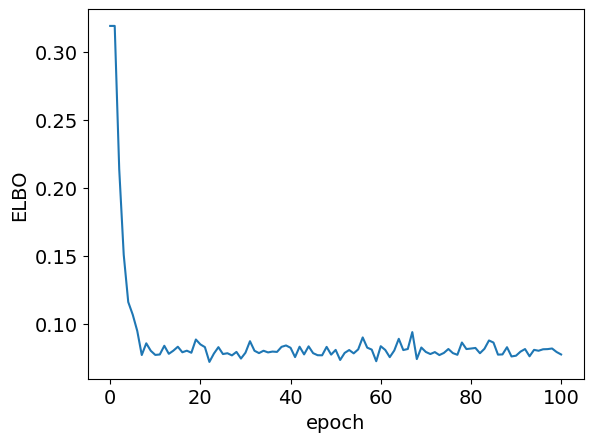

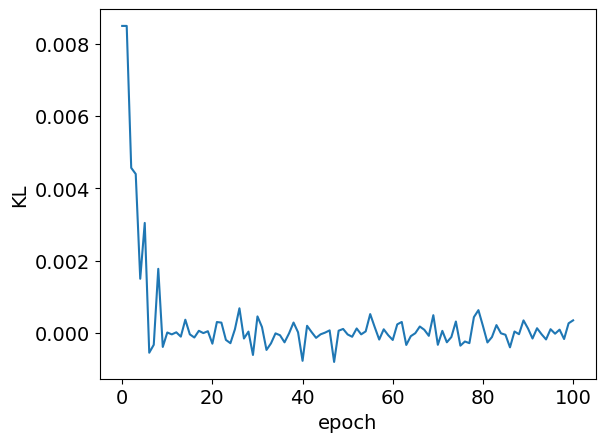

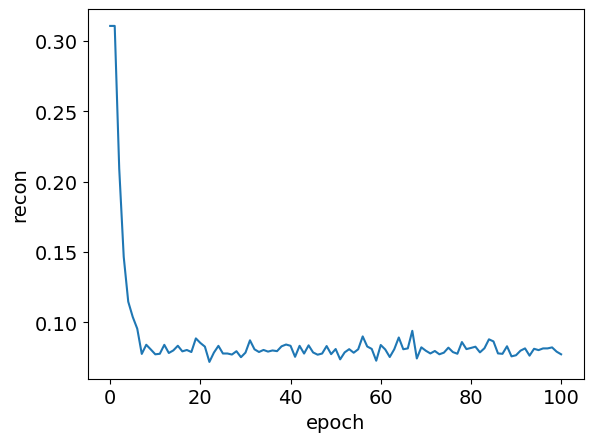

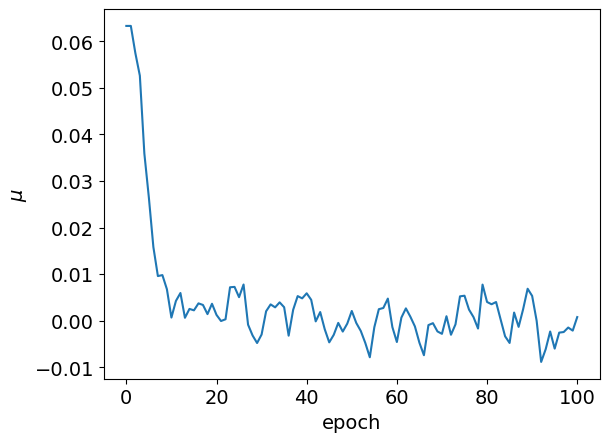

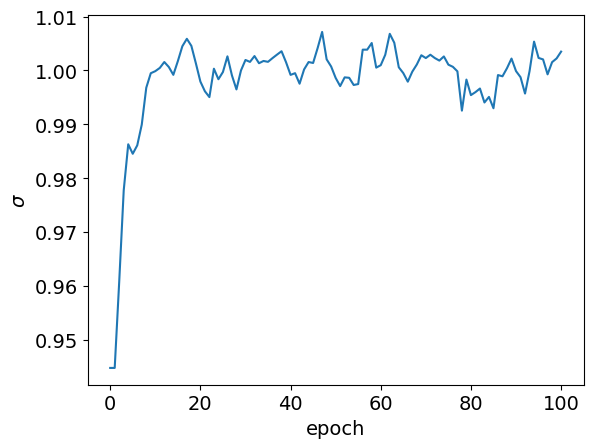

In [77]:
fig, ax = plt.subplots()
ax.plot(metrics['elbo'])
ax.set_ylabel('ELBO')
ax.set_xlabel('epoch')
plt.savefig(f'elbo.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(metrics['kl'])
ax.set_ylabel('KL')
ax.set_xlabel('epoch')
plt.savefig(f'kl.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(metrics['recon_loss'])
ax.set_ylabel('recon')
ax.set_xlabel('epoch')
plt.savefig(f'recon.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(metrics['mu'])
ax.set_ylabel('$\mu$')
ax.set_xlabel('epoch')
plt.savefig(f'mu.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(metrics['std'])
ax.set_ylabel('$\sigma$')
ax.set_xlabel('epoch')
plt.savefig(f'sigma.pdf', bbox_inches='tight')


In [55]:
encoded = []
decoded = []
#print(output)
encodedColumns = [f'latent{i}' for i in range(1, latent_dim+1)]
for sampName in sorted(pandas.unique(scaledData.sampName)):
    tempData = torch.Tensor(scaledData[scaledData.sampName==sampName][trainBranches].to_numpy())
    # if torch.cuda.is_available():
    #         tempData = tempData.cuda()
    encodedData = model.encoder(tempData)
    
    decodedData = model.decoder(encodedData).cpu().detach().numpy()
    tempDF = pandas.DataFrame(encodedData.cpu().detach().numpy(), columns=encodedColumns)
    tempDF['sampName'] = sampName
    encoded.append(tempDF)
    tempDF = pandas.DataFrame(decodedData, columns=trainBranches)
    tempDF['sampName'] = sampName
    decoded.append(tempDF)

allEncoded = pandas.concat(encoded)
allDecoded = pandas.concat(decoded)
# Now save the encoder data to be used for clustering later
allEncoded.to_hdf(f'encodedData{sigStr}_latentDim{latent_dim}.h5', key='encoded', mode='w')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (14484x32 and 1x32)

In [53]:
# This shows the latent spacce distributions for the two signals. Essentially we have trained a unsupervised
# classifier since labels were not given to the NN. The latent space is overly simple here (1D).
# We can applying clustering to this latent space and avoid high dimensionality and essentially
# summarize low-level variables. A variational auto-encoder would make these nice Gaussians at which point
# we may be able to use model-based clustering (k-means will also work).
fig, ax = plt.subplots()
totalEncodedDist = allEncoded.drop('sampName', axis=1)
nBins = 30
if totalEncodedDist.shape[1] == 2:
    xMin, yMin = np.min(totalEncodedDist, axis=0)
    xMax, yMax = np.max(totalEncodedDist, axis=0)
    dX = (xMax-xMin)/nBins
    dY = (yMax-yMin)/nBins
    print(xMin, xMax, dX, yMin, yMax, dY)
    bins2d = [[xMin+i*dX for i in range(nBins+2)], [yMin+i*dY for i in range(nBins+2)]]
    a = plt.hist2d(totalEncodedDist.latent1, totalEncodedDist.latent2, bins=bins2d,)
    ax.set_ylabel('Latent space 2')
elif totalEncodedDist.shape[1] == 1:
    xMin = np.min(totalEncodedDist.to_numpy(), axis=0)[0]
    xMax = np.max(totalEncodedDist.to_numpy(), axis=0)[0]
    dX = (xMax-xMin)/nBins
    print(xMin, xMax, dX)
    bins = [xMin+i*dX for i in range(nBins+3)]
    a = plt.hist(totalEncodedDist.latent1, histtype='step', bins=bins)
ax.set_xlabel('Latent space 1')
plt.savefig(f'latentSpace{sigStr}_latentDim{latent_dim}.pdf', bbox_inches='tight')
plt.savefig(f'latentSpace{sigStr}_latentDim{latent_dim}.svg', bbox_inches='tight')
plt.savefig(f'latentSpace{sigStr}_latentDim{latent_dim}.png', bbox_inches='tight')

NameError: name 'allEncoded' is not defined

NameError: name 'allEncoded' is not defined

In [54]:
colorMaps = [plt.cm.Reds, plt.cm.Blues, plt.cm.Greys]
colors = ['r', 'b', 'g']
markerstyles=['.' for c in colors]
custom_lines = [Line2D([0], [0], color=color, lw=2) for color in colors]
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
fontsize=8
plotSamps = ['sig_1300_1', 'sig_500_1', 'sig_700_400']
fontsize=18
fig, ax = plt.subplots()
for color, cmap, sampLabel in zip(colors, colorMaps, plotSamps):
    legHandles = [mpatches.Patch(color=color, label=sampLabel)]
    plotDist = allEncoded[allEncoded.sampName==sampLabel].drop('sampName', axis=1)
    if plotDist.shape[1] == 2:
        fig, ax = plt.subplots()
        plt.hist2d(plotDist.latent1, plotDist.latent2, bins=bins2d, cmap=cmap, label=sampLabel)#, weights=sampData.weight)
        ax.set_xlabel('Latent space 1', fontsize=fontsize)
        ax.set_ylabel('Latent space 2', fontsize=fontsize)
        ax.set_xlabel('Latent space 1', fontsize=fontsize)
        ax.legend(ncol=1, handles=legHandles, fontsize=fontsize, loc=0)
        plt.tight_layout(pad=0.0)
        plt.margins(0,0)
        
        plt.savefig(f"latentSpace_{sampLabel}{sigStr}_{latent_dim}DHist.svg",bbox_inches='tight', pad_inches=0)
        plt.savefig(f"latentSpace_{sampLabel}{sigStr}_{latent_dim}DHist.pdf",bbox_inches='tight', pad_inches=0)
    elif plotDist.shape[1] == 1:
        plt.hist(plotDist.latent1, histtype='step', bins=bins, color=color, label=sampLabel, weights=np.ones(plotDist.latent1.shape)/plotDist.latent1.shape[0])
    
if plotDist.shape[1] == 1:
    ax.set_xlabel('Latent space 1', fontsize=fontsize)
    ax.set_ylabel('Percent of total', fontsize=fontsize)
    ax.legend(ncol=1, fontsize=fontsize, loc=2)
    ax.set_ylim([0, ax.get_ylim()[1]*1.1])
    plt.tight_layout(pad=0.0)
    plt.margins(0,0)
    plt.savefig(f"latentSpace_{sampLabel}{sigStr}_{latent_dim}DHist.svg",bbox_inches='tight', pad_inches=0)
    plt.savefig(f"latentSpace_{sampLabel}{sigStr}_{latent_dim}DHist.pdf",bbox_inches='tight', pad_inches=0)  

NameError: name 'Line2D' is not defined